<a href="https://colab.research.google.com/github/samratkar/samratkar.github.io/blob/main/Industry_Project_LLM_Prod_Topic_Modeling_with_Quantized_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://i.imgur.com/C4ROBqP.jpeg">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [ ]:
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [ ]:
from datasets import load_dataset

# ArXiv ML Documents
#docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]
docs = load_dataset("Tobi-Bueck/customer-support-tickets")["train"]["body"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/986 [00:00<?, ?B/s]

ML-Arxiv-Papers.csv:   0%|          | 0.00/147M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117592 [00:00<?, ? examples/s]

# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [ ]:
!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

--2025-08-06 08:51:14--  https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/65/3b/653b1cc7a4558cd22c0ac02df471105878a080cb5694622ccd566697c574592f/cd58120326971c71c0590f6b7084a0744e287ce9c67275d8b4bf34a5947d950b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27openhermes-2.5-mistral-7b.Q4_K_M.gguf%3B+filename%3D%22openhermes-2.5-mistral-7b.Q4_K_M.gguf%22%3B&Expires=1754473874&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1NDQ3Mzg3NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzY1LzNiLzY1M2IxY2M3YTQ1NThjZDIyYzBhYzAyZGY0NzExMDU4NzhhMDgwY2I1Njk0NjIyY2NkNTY2Njk3YzU3NDU5MmYvY2Q1ODEyMDMyNjk3MWM3

Next, we load the model using `llama-cpp-python`:

In [ ]:
!pip install -q llama-cpp-python


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

In [ ]:
docs = list(docs)


We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [ ]:

from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:

from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3675 [00:00<?, ?it/s]

[2025-08-06 08:56:56.234] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [ ]:
# Define sub-models
#umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
#hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

umap_model = UMAP(
    n_neighbors=10,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

# Allow clusters down to 50 points, use leaf extraction
hdbscan_model = HDBSCAN(
    min_cluster_size=650,
    min_samples=12,
    metric='euclidean',
    cluster_selection_method='leaf',
    prediction_data=True
)

[2025-08-06 09:04:09.763] [CUML] [info] build_algo set to brute_force_knn because random_state is given


# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-08-06 09:04:11,365 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-06 09:04:13,436 - BERTopic - Dimensionality - Completed ✓
2025-08-06 09:04:13,439 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-06 09:04:15,324 - BERTopic - Cluster - Completed ✓
2025-08-06 09:04:15,346 - BERTopic - Representation - Fine-tuning topics using representation models.
  0%|          | 0/39 [00:00<?, ?it/s]Llama.generate: 44 prefix-match hit, remaining 1646 prompt tokens to eval
llama_perf_context_print:        load time =   45749.35 ms
llama_perf_context_print: prompt eval time =  350690.38 ms /  5483 tokens (   63.96 ms per token,    15.63 tokens per second)
llama_perf_context_print:        eval time =    2170.28 ms /    16 runs   (  135.64 ms per token,     7.37 tokens per second)
llama_perf_context_print:       total time =   62930.56 ms /  5499 tokens
  3%|▎         | 1/39 [01:02<39:51, 62.94s/it]Llama.generate: 44 prefix-match hit, remai

Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,61798,-1_the_of_and_to,"[the, of, and, to, in, we, for, is, that, on]","[models, model, learning, algorithms, networks...","[Machine Learning, Graphs, Clustering, Network...",[ A central issue of many statistical learnin...
1,0,4155,0_policy_learning_reinforcement_rl,"[policy, learning, reinforcement, rl, the, to,...","[robots, dynamics, learning, reinforcement, ro...",[Reinforcement Learning Algorithms and Applica...,[ Deep reinforcement learning agents have rec...
2,1,3263,1_speech_audio_speaker_the,"[speech, audio, speaker, the, to, and, of, mus...","[speech, voice, language, models, model, neura...","[Speech Separation and Synthesis, , , , , , , ...",[ Despite the close relationship between spee...
3,2,2811,2_language_the_to_word,"[language, the, to, word, and, of, we, models,...","[embeddings, embedding, nlp, multilingual, lan...","[Language models, word embeddings, translation...",[ Sense representations have gone beyond word...
4,3,2784,3_the_of_label_in,"[the, of, label, in, and, to, is, we, for, data]","[classifiers, supervised, classifier, regressi...","[Multi-label Classification Methods, , , , , ,...","[ In binary classification problems, mainly t..."
5,4,2623,4_generative_the_gans_gan,"[generative, the, gans, gan, of, to, and, we, ...","[gans, adversarial, generative, gan, autoencod...","[Generative Models, Latent Variables, GANs, Im...",[ Generative Adversarial Networks (GANs) have...
6,5,2396,5_adversarial_attacks_attack_robustness,"[adversarial, attacks, attack, robustness, exa...","[adversarial, adversarially, dnns, dnn, attack...",[Adversarial Attacks and Robustness in Deep Le...,[ It has been consistently reported that many...
7,6,1990,6_regret_bandit_the_algorithm,"[regret, bandit, the, algorithm, we, bandits, ...","[bandits, stochastic, optimization, optimal, a...","[Bandit Algorithms and Regret Bounds, , , , , ...",[ We investigate online convex optimization i...
8,7,1945,7_3d_object_the_and,"[3d, object, the, and, to, of, we, in, on, seg...","[convolutional, 3d, models, segmentation, mode...","[3D Object Detection, , , , , , , , , ]","[ Given two consecutive RGB-D images, we prop..."
9,8,1928,8_user_recommendation_items_item,"[user, recommendation, items, item, the, users...","[recommender, embedding, prediction, models, r...","[Sequential Recommendation Framework, , , , , ...",[ We consider an online model for recommendat...


# 📊 Visualization with DataMapPlot

In [ ]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

Calculating medoids: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

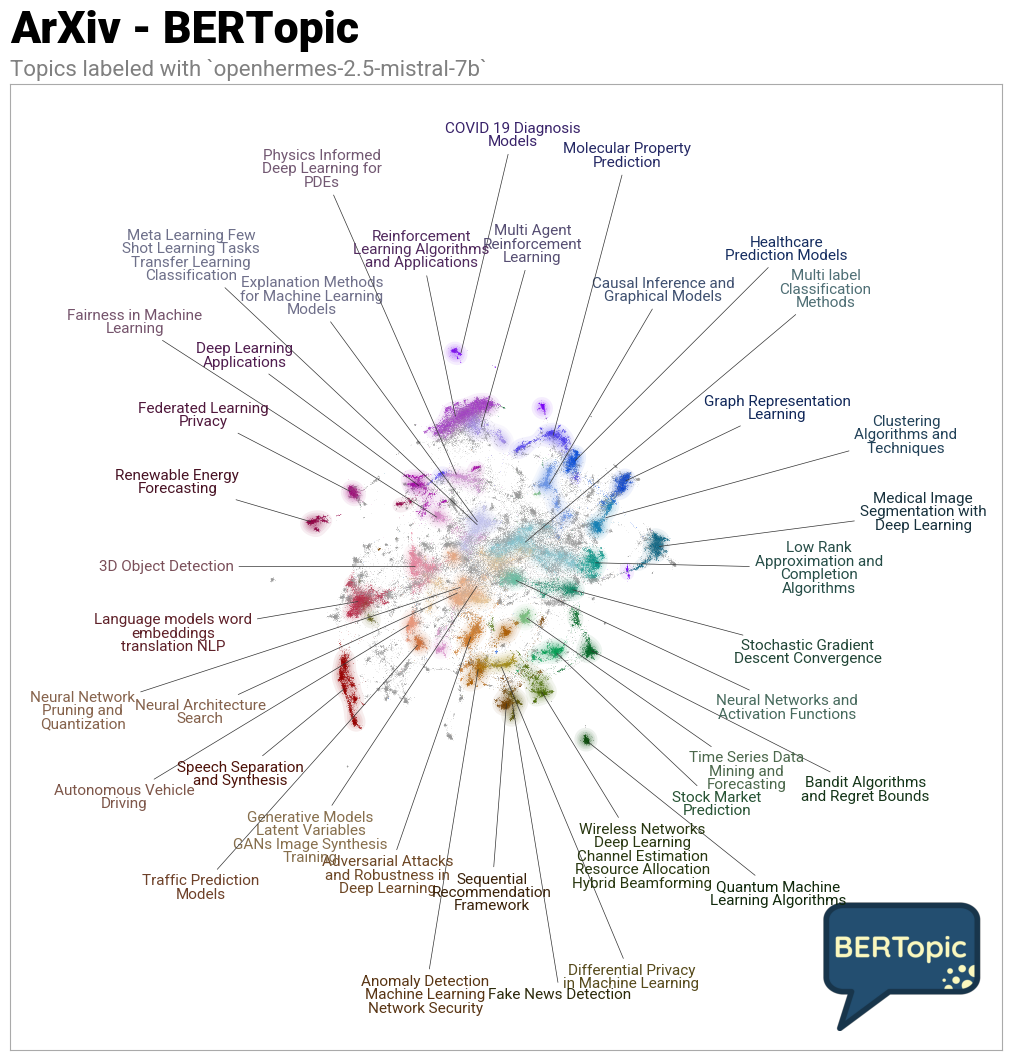

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)